# Building and Tuning the Models

- Amazon Art scraped data for prints: data, data dictionary
- Each observation represents a diffrent print
- Goal: Predict print price per square inch based on the data and the extracted features
- Models: Logistic Regression, Naive Bayes, Decision Tree, and Random Forest


## Part 1: Logistic Regression and Naive Bayes: Predicting Price Based on Artist

We will predict the price per square inch of a print based solely on the artist as one of the first hypothesis was that the price of a piece of work has less to do with the actual print and more with the popularity and status of the artist.

We will try both a **Logistic Regression** and a **Naive Bayes** model. As seen in the EDA, since the classes are unbalanced Naive Bayes is expected to perform at least slightly better.

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# allow plots to appear in the notebook
%matplotlib inline

### Preparing the Data

In [71]:
# read in the cleaned data prepared in the EDA notebook
url = 'data/modelready_df.csv'
model_df = pd.read_csv(url)

# remove 'Unnamed: 0' column
model_df.drop('Unnamed: 0', axis = 1, inplace= True)

# double check for null values
model_df.isnull().sum()

artist              0
description       739
height              0
image               0
price               0
size                2
title               0
url_id              0
width               0
area                0
price_sqin          0
price_class         0
avg_r_value         0
avg_g_value         0
avg_b_value         0
avg_hue             0
avg_saturation      0
avg_value           0
dtype: int64

In [72]:
# fill null values for description with and empty string 
model_df['description'] = model_df.description.fillna(value = '')

# fill 2 null values for size, note the size is already captured in the width and height columns
model_df['size'] = model_df['size'].fillna(value = 'see height/width')

In [73]:
model_df.head(2)

,artist,description,height,image,price,size,title,url_id,width,area,price_sqin,price_class,avg_r_value,avg_g_value,avg_b_value,avg_hue,avg_saturation,avg_value
0,alexandra mas,"It is part of ""Préconçue"" art show, against pr...",47.24,http://ecx.images-amazon.com/images/I/519lYUvA...,5100.0,"[u'47.24', u'31.5', u'3.94 in.']","For sale,",B015EOYYEE,31.5,1488.06,3.427281,4.0,99.576264,86.109942,79.650188,44.528990,49.881317,99.874837
1,joel degrand,"Uniforms, Outfits, & Accessories We think of t...",90.00,http://ecx.images-amazon.com/images/I/51MCovXG...,10000.0,"[u'90', u'72', u'0.5 in.']","Steve, Fireman, Beverly Shores, IN,",B00IRTE78C,72.0,6480.00,1.543210,4.0,134.264499,89.615733,95.596077,101.140679,98.397558,142.234524


In [74]:
# create dummy variables for each artist
artist_dummies = pd.get_dummies(data = model_df.artist)

# drop one column to prevent multicolinearity
artist_dummies.drop(artist_dummies.columns[0], axis=1, inplace=True)

In [75]:
model_df.loc[model_df.price_sqin < .50, 'price_class'] = 0
model_df.loc[(model_df.price_sqin >= .50) & (model_df.price_sqin < 1), 'price_class'] = 1
model_df.loc[(model_df.price_sqin >= 1) & (model_df.price_sqin < 2), 'price_class'] = 2
model_df.loc[(model_df.price_sqin >= 2) & (model_df.price_sqin < 10), 'price_class'] = 3
model_df.loc[(model_df.price_sqin >= 10) & (model_df.price_sqin < 50), 'price_class'] = 4
model_df.loc[(model_df.price_sqin >= 50) & (model_df.price_sqin < 200), 'price_class'] = 5
model_df.loc[(model_df.price_sqin >= 200), 'price_class'] = 6

In [76]:
print model_df.shape, artist_dummies.shape

# concatinate the two dataframes
art_artist = pd.concat([model_df, artist_dummies], ignore_index= False, axis = 1, verify_integrity = True)
art_artist.shape

(4526, 18) (4526, 640)


(4526, 658)

### Logistic Model

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from nltk import ConfusionMatrix

# define a logistic regression model

def artist_logreg(X, y):
    # cross validate
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    # fit a logistic regression and store the class predictions
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_class = logreg.predict(X_test)

    # calculate accuracy
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)
    print ConfusionMatrix(list(y_test), list(y_pred_class))

    # calculate null accuracy
    print 'Null Accuracy Rate: ', float(model_df.price_class.value_counts().max())/len(model_df.price_class)

In [78]:
# define X and y
X = artist_dummies
y = model_df.price_class

artist_logreg(X, y)

Accuracy:  0.782685512367
    |   0   1   2   3   4   5   6 |
    |   .   .   .   .   .   .   . |
    |   0   0   0   0   0   0   0 |
----+-----------------------------+
0.0 | <32> 22   .   6   .   .   . |
1.0 |   3<132> 28  27   .   .   . |
2.0 |   .  34<249> 34   .   .   . |
3.0 |   .   .  29<414> 13   .   . |
4.0 |   .   .   .  40 <56>  .   . |
5.0 |   .   .   .   5   4  <3>  . |
6.0 |   .   .   .   .   1   .  <.>|
----+-----------------------------+
(row = reference; col = test)

Null Accuracy Rate:  0.392620415378


### Naive Bayes

In [79]:
from sklearn.naive_bayes import MultinomialNB
# define a Naive-Bayes model

def artist_nb(X, y):
    # cross validate
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    # fit a logistic regression and store the class predictions
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_pred_class = nb.predict(X_test)

    # calculate accuracy
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)
    print ConfusionMatrix(list(y_test), list(y_pred_class))

    # calculate null accuracy
    print 'Null Accuracy Rate: ', float(model_df.price_class.value_counts().max())/len(model_df.price_class)

In [80]:
# define X and y
X = artist_dummies
y = model_df.price_class

artist_nb(X, y)

Accuracy:  0.78445229682
    |   0   1   2   3   4   5   6 |
    |   .   .   .   .   .   .   . |
    |   0   0   0   0   0   0   0 |
----+-----------------------------+
0.0 | <27> 27   .   6   .   .   . |
1.0 |   .<146> 28  16   .   .   . |
2.0 |   .  35<243> 39   .   .   . |
3.0 |   .   .  22<424> 10   .   . |
4.0 |   .   .   .  51 <45>  .   . |
5.0 |   .   .   .   5   4  <3>  . |
6.0 |   .   .   .   .   1   .  <.>|
----+-----------------------------+
(row = reference; col = test)

Null Accuracy Rate:  0.392620415378


We see that we can predict the price per sqin of a print with 78.4% accuracy based solely on the artist.

## Part 2: Natural Language Processing: Classifying Price Based on Description

Since visual content analysis is not in the scope of this project, the we will use the artist written description as a proxy for artwork content. 

### Tokenization

In [81]:
#fit using Logistic Regression
def tokenize_logreg(vect):
    #cross validate
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    #create a document term matrix
    X_train_dtm = vect.fit_transform(X_train)
    print 'Features: ', X_train_dtm.shape[1]
    X_test_dtm = vect.transform(X_test)
    
    # use logistic regression with text column only
    logreg = LogisticRegression()
    logreg.fit(X_train_dtm, y_train)
    y_pred_class = logreg.predict(X_test_dtm)
    
    # calculate accuracy
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)    

#Fit using Naive Bayes
def tokenize_nb(vect):
    #cross validate
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    #create a document term matrix
    X_train_dtm = vect.fit_transform(X_train)
    print 'Features: ', X_train_dtm.shape[1]
    X_test_dtm = vect.transform(X_test)
    
    # use logistic regression with text column only
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    
    # calculate accuracy
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)

In [152]:
# define a function that accepts text and returns a list of lemmas
# def split_into_lemmas(text):
#     try:
#         text = unicode(text, 'utf-8').lower()
#         words = TextBlob(text).words
#         return [word.lemmatize() for word in words]
#     except:
#         return text.split(' ')
from textblob import TextBlob, Word

def split_into_lemmas(text):
    text = unicode(text, 'utf-8').lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]


In [83]:
#define X and y
X = model_df.loc[:,'description']
y = model_df.loc[:,'price_class']

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect1 = CountVectorizer(ngram_range=(1,2), stop_words= 'english', min_df = 2)
# use split_into_lemmas as the feature extraction function
vect2 = CountVectorizer(ngram_range=(1,2), stop_words= 'english', min_df = 2, analyzer=split_into_lemmas)
vect3 = TfidfVectorizer(ngram_range=(1,2), stop_words= 'english', min_df = 2)

vects = [vect1, vect2, vect3]
for i in vects:
    print tokenize_logreg(i), tokenize_nb(i)
    

print 'Null Accuracy Rate: ', float(model_df.price_class.value_counts().max())/len(model_df.price_class)

Features:  16997
Accuracy:  0.706713780919
None Features:  16997
Accuracy:  0.658127208481
None
Features:  7573
Accuracy:  0.695229681979
None Features:  7573
Accuracy:  0.632508833922
None
Features:  16997
Accuracy:  0.687279151943
None Features:  16997
Accuracy:  0.678445229682
None
Null Accuracy Rate:  0.392620415378


We see that the Logistic Regression consistently does better than Naive Bayes in classiying the correct price bin.

Though the regular CountVectorizer has a higher accuracy, the count vectorizer that splits the words into lemmas has a comprable accuracy but significanly less features. We will thus choose the vectorizer that uses lemmas.

## Part 3: Building and tuning decision trees and Random Forests

### Preparing the data

In [85]:
# read in the symmetry dataframe containing crossplane and inplane symmetry
symmetry_df = pd.read_csv('symmetry_df.csv')
symmetry_df.drop(['Unnamed: 0', 'image'], axis =1, inplace = True)

# concatinate with model_df
art_sym = pd.concat([model_df, symmetry_df], axis =1)
print symmetry_df.shape, model_df.shape, art_sym.shape
print art_sym.columns

(4526, 2) (4526, 18) (4526, 20)
Index([u'artist', u'description', u'height', u'image', u'price', u'size',
       u'title', u'url_id', u'width', u'area', u'price_sqin', u'price_class',
       u'avg_r_value', u'avg_g_value', u'avg_b_value', u'avg_hue',
       u'avg_saturation', u'avg_value', u'crossplane_sym', u'inplane_sym'],
      dtype='object')


In [86]:
art_sym.isnull().sum()

# remove rows with missing values (due to missing symmetry values)
art_sym.dropna(axis = 0, how = 'any', subset = ['crossplane_sym', 'inplane_sym'], inplace = True)

print art_sym.isnull().sum().sum()

0


In [87]:
# define features
feature_cols = ['area', 'avg_r_value', 'avg_g_value', 'avg_b_value', 'avg_hue',
       'avg_saturation', 'avg_value', 'crossplane_sym', 'inplane_sym']

# define X and y
X = art_sym[feature_cols]
y = art_sym.price_class

In [88]:
print X.shape, y.shape, y.value_counts()

(3790, 9) (3790,) 3.0    1460
2.0     989
1.0     699
4.0     366
0.0     200
5.0      68
6.0       8
Name: price_class, dtype: int64


### Classifying price with a decision tree

Find the best **max_depth** for a decision tree using cross-validation:


In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# list of values to try for max_depth
max_depth_range = range(2, 21)

# list to store the average accuracy for each value of max_depth
accuracy_scores = []

# use cross-validation with each value of max_depth
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_score = cross_val_score(treeclf, X, y, cv=5, scoring='accuracy')
    accuracy_scores.append(accuracy_score.mean())


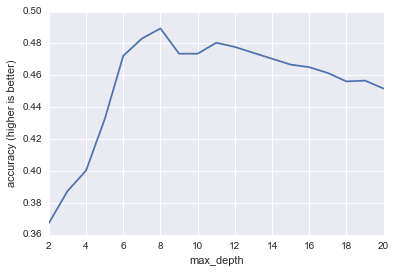

In [90]:
# plot max_depth (x-axis) versus accuracy (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy (higher is better)')

In [91]:
treeclf = DecisionTreeClassifier(max_depth=8, random_state=1)
treeclf.fit(X, y)


9 9


In [92]:
# compute feature importances
pd.DataFrame({'feature': feature_cols, 'importance':treeclf.feature_importances_}).sort('importance')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
1,avg_r_value,0.013654
7,crossplane_sym,0.023130
8,inplane_sym,0.027255
6,avg_value,0.049186
3,avg_b_value,0.049320
2,avg_g_value,0.053809
4,avg_hue,0.064973
5,avg_saturation,0.071048
0,area,0.647627


In [93]:
rftreeclf = RandomForestClassifier(max_depth=1000)

X_train, X_test, y_train, y_test = train_test_split(X, y)

rftreeclf.fit(X_train, y_train)
preds = rftreeclf.predict(X_test)

treeclf.score(X_train, y_train)
print metrics.accuracy_score(y_test, preds)

0.497890295359


### Classifying price with a Random Forest

In [94]:
rfclf = RandomForestClassifier()

#### Turning n_estimators

Here we will look for an **n** number of trees grown so that the error stabilizes.

In [95]:
# list of values to try for n_estimators
estimator_range = range(10, 510, 10)

# list to store the average accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimatorsfro
for estimator in estimator_range:
    rfclf = RandomForestClassifier(n_estimators=estimator, random_state=1)
    accuracy_score = cross_val_score(rfclf, X, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(accuracy_score))

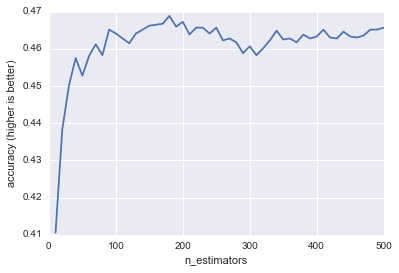

In [96]:
# plot n_estimators (x-axis) versus accuracy (y-axis)
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy (higher is better)')

#### Tuning max_features

In [98]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average accuracy for each value of max_features
accuracy_scores = []

# use 5-fold cross-validation with each value of max_features
for feature in feature_range:
    rfclf = RandomForestClassifier(n_estimators=350, max_features=feature, random_state=1)
    accuracy_score = cross_val_score(rfclf, X, y, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(accuracy_score))

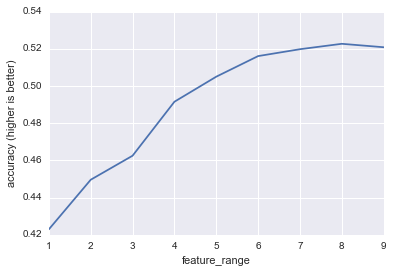

In [99]:
# plot feature_range (x-axis) versus accuracy (y-axis)
plt.plot(feature_range, accuracy_scores)
plt.xlabel('feature_range')
plt.ylabel('accuracy (higher is better)')

In [104]:
# show the best accuracy and the corresponding max_features
max(sorted(zip(accuracy_scores, feature_range)))

(0.52266412839739385, 8)

### Fitting a Random Forest with the best parameters


In [109]:
# max_features=8 is best and n_estimators=350 is sufficiently large for error to stabilize
rfclf = RandomForestClassifier(n_estimators= 350, max_features= 8, oob_score=True, random_state=1)
rfclf.fit(X, y)
print 'Accuracy Score: ', np.mean(cross_val_score(rfclf, X, y, cv=5, scoring='accuracy'))
print 'Out of Bag Score: ', rfclf.oob_score_

Accuracy Score:  0.522664128397
Out of Bag Score:  0.610817941953


In [102]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfclf.feature_importances_}).sort('importance')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
1,avg_r_value,0.070402
6,avg_value,0.070818
2,avg_g_value,0.075597
3,avg_b_value,0.076908
5,avg_saturation,0.103728
4,avg_hue,0.105140
8,inplane_sym,0.106354
7,crossplane_sym,0.107661
0,area,0.283392


In [103]:
# compute the out-of-bag accuracy score
rfclf.oob_score_

0.6108179419525066

## Classifying with Image Data and Document Matrix

### Preparing the data


In [153]:
# read in the symmetry dataframe again since we dropped some values
symmetry_df = pd.read_csv('symmetry_df.csv')
symmetry_df.drop(['Unnamed: 0', 'image'], axis =1, inplace = True)

# concatinate with model_df
art_sym = pd.concat([model_df, symmetry_df], axis =1)

print symmetry_df.shape, model_df.shape, art_sym.shape
print art_sym.columns

(4526, 2) (4526, 18) (4526, 20)
Index([u'artist', u'description', u'height', u'image', u'price', u'size',
       u'title', u'url_id', u'width', u'area', u'price_sqin', u'price_class',
       u'avg_r_value', u'avg_g_value', u'avg_b_value', u'avg_hue',
       u'avg_saturation', u'avg_value', u'crossplane_sym', u'inplane_sym'],
      dtype='object')


In [154]:
art_sym.isnull().sum()

# remove rows with missing values (due to missing symmetry values)
art_sym.dropna(axis = 0, how = 'any', subset = ['crossplane_sym', 'inplane_sym'], inplace = True)

print art_sym.isnull().sum().sum()
art_sym.reset_index(drop=True, inplace=True)
art_sym.shape

0


(3790, 20)

In [155]:
#we need to concatinate the predictor columns from art_sym with the doc_matrix
feature_cols = ['description', 'area', 'avg_r_value', 'avg_g_value', 'avg_b_value', 'avg_hue',
       'avg_saturation', 'avg_value', 'crossplane_sym', 'inplane_sym']

In [156]:
# define X and y
X = art_sym[feature_cols]
y = art_sym['price_class']

print type(X), type(y)
print len(X), len(y)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
3790 3790


In [157]:
# use CountVectorizer with description column only
#vect = CountVectorizer(ngram_range=(1,2), stop_words= 'english', min_df = 2, tokenizer=split_into_lemmas)
vect = CountVectorizer(ngram_range=(1,2), stop_words= 'english', min_df = 2, analyzer=split_into_lemmas)

X_train_dtm = vect.fit_transform(X_train.description)
X_test_dtm = vect.transform(X_test.description)
print X_train_dtm.shape
print X_test_dtm.shape

(2842, 5082)
(948, 5082)


In [158]:
# shape of other nine feature columns
X_train.drop('description', axis=1).shape

(2842, 9)

In [159]:
import scipy as sp
# cast other feature columns to float and convert to a sparse matrix
extra = sp.sparse.csr_matrix(X_train.drop('description', axis=1).astype(float))
extra.shape

(2842, 9)

In [160]:
# combine sparse matrices
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

(2842, 5091)

In [161]:
# repeat for testing set
extra = sp.sparse.csr_matrix(X_test.drop('description', axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(948, 5091)

In [162]:
print y_train.shape, y_test.shape

(2842,) (948,)


### Classifying price with a decision tree

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# list of values to try for max_depth
max_depth_range = range(18, 32)

# list to store the average accuracy for each value of max_depth
accuracy_scores = []

for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    treeclf.fit(X_train_dtm_extra, y_train)
    y_pred_class = treeclf.predict(X_test_dtm_extra)
    accuracy_score = metrics.accuracy_score(y_test, y_pred_class)
    accuracy_scores.append(accuracy_score)

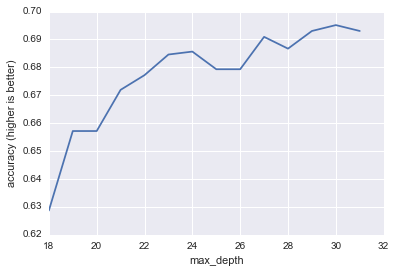

In [123]:
# plot max_depth (x-axis) versus accuracy (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy (higher is better)')

In [124]:
# training the decision tree with the best parameters

reeclf = DecisionTreeClassifier(max_depth='28', random_state=1)
treeclf.fit(X_train_dtm_extra, y_train)
y_pred_class = treeclf.predict(X_test_dtm_extra)
print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)

Accuracy:  0.693037974684


### Classifying price with a Random Forest

Tuning n_estimators

In [163]:
# list of values to try for n_estimators
estimator_range = range(10, 410, 10)

# list to store the average accuracy for each value of n_estimators
accuracy_scores = []

for estimator in estimator_range:
    rfclf = RandomForestClassifier(n_estimators=estimator, random_state=1)
    rfclf.fit(X_train_dtm_extra, y_train)
    y_pred_class = rfclf.predict(X_test_dtm_extra)
    accuracy_score = metrics.accuracy_score(y_test, y_pred_class)
    accuracy_scores.append(accuracy_score)

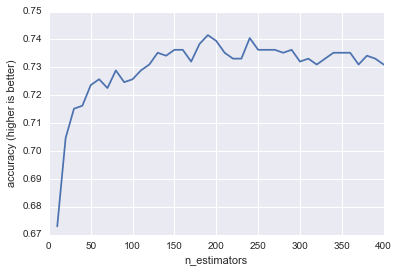

In [164]:
# plot n_estimators (x-axis) versus accuracy (y-axis)
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy (higher is better)')

In [165]:
# accuracy stabilizes around 250 n_estimators
max(sorted(zip(accuracy_scores, estimator_range)))

(0.74156118143459915, 190)

#### Tuning max_features

In [166]:
# list of values to try for max_features
feature_range = range(4999, 5010)

# list to store the average accuracy for each value of max_features
accuracy_scores = []

# use cross-validation with each value of max_features
for feature in feature_range:
    rfclf = RandomForestClassifier(n_estimators= 250, max_features=feature, random_state=1)
    rfclf.fit(X_train_dtm_extra, y_train)
    y_pred_class = rfclf.predict(X_test_dtm_extra)
    accuracy_score = metrics.accuracy_score(y_test, y_pred_class)
    accuracy_scores.append(accuracy_score)

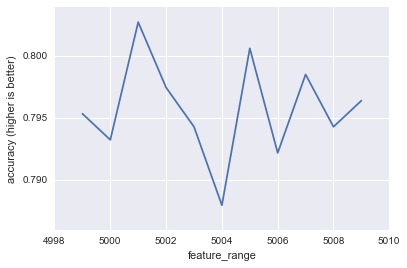

In [167]:
# plot feature_range (x-axis) versus accuracy (y-axis)
plt.plot(feature_range, accuracy_scores)
plt.xlabel('feature_range')
plt.ylabel('accuracy (higher is better)')

In [168]:
# show the best accuracy and the corresponding max_features
max(sorted(zip(accuracy_scores, feature_range)))

(0.8027426160337553, 5001)

### Fitting a Random Forest with the best parameters


In [169]:
# max_features=5001 is best and n_estimators= 250 is sufficiently large
rfclf = RandomForestClassifier(n_estimators= 250, max_features = 5001, oob_score=True, random_state=1)
rfclf.fit(X_train_dtm_extra, y_train)
y_pred_class = rfclf.predict(X_test_dtm_extra)
accuracy_score = metrics.accuracy_score(y_test, y_pred_class)

print 'Accuracy: ', accuracy_score
print 'Out of Bag Score: ', rfclf.oob_score_

Accuracy:  0.802742616034
Out of Bag Score:  0.765306122449


In [170]:
# convert X_train_dtm to a dataframe to get column headers
doc_matrix = pd.DataFrame(vect.fit_transform(X_train.description).toarray(), columns=vect.get_feature_names())

In [171]:
features = doc_matrix.columns.append(X_train.drop('description', axis=1).columns)
len(features)

5091

In [172]:
# compute feature importances
pd.DataFrame({'feature': features, 'importance':rfclf.feature_importances_}).sort('importance')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
0,'a,0.000000
2474,interaction,0.000000
2475,interactive,0.000000
2476,interchangeably,0.000000
2480,interfere,0.000000
2482,interlaced,0.000000
2485,interpret,0.000000
2469,intensely,0.000000
2486,interpretation,0.000000
2489,interweaving,0.000000


In [173]:
art_sym.corr()

,height,price,width,area,price_sqin,price_class,avg_r_value,avg_g_value,avg_b_value,avg_hue,avg_saturation,avg_value,crossplane_sym,inplane_sym
height,1.000000,0.346955,0.776548,0.906289,-0.159310,-0.139930,0.011183,-0.002215,0.005777,0.072624,0.048276,0.015719,0.051837,0.027560
price,0.346955,1.000000,0.278112,0.363233,0.359094,0.471134,-0.001491,-0.005551,-0.001655,-0.083084,-0.138490,-0.044127,0.019571,-0.016648
width,0.776548,0.278112,1.000000,0.863556,-0.188141,-0.244776,0.011152,0.012862,0.024751,0.139839,0.079760,0.041904,0.032289,0.045020
area,0.906289,0.363233,0.863556,1.000000,-0.104234,-0.120259,0.030384,0.027075,0.036036,0.100439,0.033649,0.042578,0.032895,0.021532
price_sqin,-0.159310,0.359094,-0.188141,-0.104234,1.000000,0.383700,0.008538,-0.007226,-0.028396,-0.083843,-0.050000,-0.022591,-0.012381,-0.020752
price_class,-0.139930,0.471134,-0.244776,-0.120259,0.383700,1.000000,-0.018657,-0.023426,-0.031836,-0.156105,-0.187537,-0.083276,-0.022645,-0.075092
avg_r_value,0.011183,-0.001491,0.011152,0.030384,0.008538,-0.018657,1.000000,0.902772,0.757086,-0.059101,-0.192698,0.916035,-0.073368,-0.078553
avg_g_value,-0.002215,-0.005551,0.012862,0.027075,-0.007226,-0.023426,0.902772,1.000000,0.907230,0.018720,-0.308603,0.911642,-0.096601,-0.076814
avg_b_value,0.005777,-0.001655,0.024751,0.036036,-0.028396,-0.031836,0.757086,0.907230,1.000000,0.190997,-0.366988,0.856638,-0.103460,-0.060510
avg_hue,0.072624,-0.083084,0.139839,0.100439,-0.083843,-0.156105,-0.059101,0.018720,0.190997,1.000000,0.349307,0.152769,-0.058560,0.026454


In [174]:
colors = np.array(['red', 'green', 'blue', 'yellow', 'brown', 'purple', 'white'])

In [ ]:
# K-means with 7 clusters
# define features
feature_cols_1 = ['area', 'avg_r_value', 'avg_g_value', 'avg_b_value', 'avg_hue',
       'avg_saturation', 'avg_value', 'crossplane_sym', 'inplane_sym', 'price']

feature_cols_2 = ['area', 'avg_r_value', 'avg_g_value', 'avg_b_value', 'avg_hue',
       'avg_saturation', 'avg_value', 'crossplane_sym', 'inplane_sym', 'price_sqin']


# define X
X_1 = art_sym[feature_cols_1]

from sklearn.cluster import KMeans
km = KMeans(n_clusters=7, random_state=1)
km.fit(X_1)

# create a cluster column 
art_sym['cluster_1']= km.labels_
art_sym.cluster_1.value_counts()

In [ ]:
# define X
X_2 = art_sym[feature_cols_2]

from sklearn.cluster import KMeans
km = KMeans(n_clusters=7, random_state=1)
km.fit(X_2)

# create a cluster column 
art_sym['cluster_2']= km.labels_
art_sym.cluster_2.value_counts()

In [ ]:
pd.scatter_matrix(X_2, c=colors[list(art_sym.cluster_2)], figsize=(20,20), s=100)

In [ ]:
test = art_sym[['area', 'avg_r_value', 'avg_g_value', 'avg_b_value', 'avg_hue',
       'avg_saturation', 'avg_value', 'crossplane_sym', 'inplane_sym', 'price_class', 'cluster_2']]


In [ ]:
import seaborn as sns
sns.set()

sns.pairplot(test, hue="cluster_2")

In [ ]:
art_sym.columns

In [ ]:
test = art_sym[['area', 'crossplane_sym', 'inplane_sym', 'price', 'cluster_1']]

sns.pairplot(test, hue="cluster_1")

In [ ]:
sns.boxplot(x="price_class", y="a", data=art_sym, palette="PRGn")
sns.despine(offset=10, trim=True)